# 🧠 Training LSTM and CNN Models for Smart Contract Vulnerability Detection

This notebook implements and trains the LSTM and CNN architectures to complement our existing CodeBERT model.

## 📋 Objectives
1. Train OptimizedLSTM for sequential pattern detection
2. Train OptimizedCNN for structural feature extraction  
3. Compare performance with CodeBERT baseline
4. Prepare models for ensemble training

## 🏗️ Architecture Overview

### LSTM Architecture
- **Purpose**: Capture sequential dependencies in Solidity code
- **Features**: Bidirectional LSTM + Attention mechanism + Residual connections
- **Input**: Token sequences from CodeBERT tokenizer

### CNN Architecture  
- **Purpose**: Extract local structural patterns and n-gram features
- **Features**: Multi-kernel convolution + Global max pooling + Batch normalization
- **Input**: Token sequences from CodeBERT tokenizer

In [2]:
# Import required libraries
import os
import sys
import json
import pickle
import time
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from collections import defaultdict

# Data manipulation
import pandas as pd
import numpy as np

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Transformers for tokenizer
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Custom utilities
from notebook_utils import (
    quick_setup, ProjectConfig, 
    OptimizedLSTM, OptimizedCNN, VulnerabilityDataset,
    load_datasets, load_model_components
)

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful!")

✅ All imports successful!


In [3]:
# Setup environment and configuration
config = quick_setup(print_info=True)
device = config.get_device()

# Create timestamp for this training run
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"\n🕒 Training session: {TIMESTAMP}")

🔧 PROJECT CONFIGURATION
Base directory: /home/netweb/vasu/smart-contract-vuln-detector
Data directory: /home/netweb/vasu/smart-contract-vuln-detector/data/processed
Results directory: /home/netweb/vasu/smart-contract-vuln-detector/results
Models directory: /home/netweb/vasu/smart-contract-vuln-detector/models
Model: microsoft/codebert-base
Max length: 512
Batch size: 16
Device: cuda
GPU: NVIDIA RTX 4000 Ada Generation
CUDA version: 12.8
🚀 PYTORCH ENVIRONMENT
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA RTX 4000 Ada Generation
GPU Memory: 21.0 GB
Using device: cuda

🕒 Training session: 20251116_164028


## 📂 Load Datasets and Configuration

In [4]:
# Load datasets and model components
print("📂 Loading datasets and configuration...")

train_df, val_df, test_df = load_datasets(config)
tokenizer, label_encoder, dataset_config = load_model_components(config)

# Configuration parameters
MODEL_NAME = config.MODEL_NAME
MAX_LENGTH = config.MAX_LENGTH
BATCH_SIZE = config.BATCH_SIZE
VOCAB_SIZE = tokenizer.vocab_size

print(f"\n🔧 Model Configuration:")
print(f"Tokenizer: {MODEL_NAME}")
print(f"Vocabulary size: {VOCAB_SIZE:,}")
print(f"Max sequence length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")

print(f"\n🏷️ Labels: {list(label_encoder.classes_)}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# For this training, we'll use binary classification
NUM_CLASSES = 1  # Binary classification with BCEWithLogitsLoss
TASK_TYPE = 'binary'

print(f"\n📊 Training Configuration:")
print(f"Task: {TASK_TYPE}")
print(f"Number of output classes: {NUM_CLASSES}")

📂 Loading datasets and configuration...
📊 DATASETS LOADED
Train: 10,032 samples
Validation: 3,344 samples
Test: 3,344 samples

🔧 Model Configuration:
Tokenizer: microsoft/codebert-base
Vocabulary size: 50,265
Max sequence length: 512
Batch size: 16

🏷️ Labels: ['Overflow-Underflow', 'Re-entrancy', 'SAFE', 'TOD', 'Timestamp-Dependency', 'Unchecked-Send', 'Unhandled-Exceptions', 'tx.origin']
Number of classes: 8

📊 Training Configuration:
Task: binary
Number of output classes: 1

🔧 Model Configuration:
Tokenizer: microsoft/codebert-base
Vocabulary size: 50,265
Max sequence length: 512
Batch size: 16

🏷️ Labels: ['Overflow-Underflow', 'Re-entrancy', 'SAFE', 'TOD', 'Timestamp-Dependency', 'Unchecked-Send', 'Unhandled-Exceptions', 'tx.origin']
Number of classes: 8

📊 Training Configuration:
Task: binary
Number of output classes: 1


In [5]:
# Create datasets and data loaders
print("🔄 Creating datasets and data loaders...")

# Create datasets
train_dataset = VulnerabilityDataset(train_df, tokenizer, MAX_LENGTH, label_type='binary')
val_dataset = VulnerabilityDataset(val_df, tokenizer, MAX_LENGTH, label_type='binary')
test_dataset = VulnerabilityDataset(test_df, tokenizer, MAX_LENGTH, label_type='binary')

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"✅ Data loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

🔄 Creating datasets and data loaders...
✅ Data loaders created:
Train batches: 627
Validation batches: 209
Test batches: 209


## ⚙️ Training Configuration

In [6]:
# Training hyperparameters for both LSTM and CNN
TRAINING_CONFIG = {
    # General training parameters
    'epochs': 10,
    'learning_rate': 1e-3,  # Higher LR for training from scratch
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'max_grad_norm': 1.0,
    
    # Evaluation and saving
    'eval_steps': 200,
    'save_steps': 500,
    'logging_steps': 50,
    
    # Early stopping
    'early_stopping_patience': 5,
    'early_stopping_metric': 'f1',
    'early_stopping_min_delta': 0.001,
    
    # Scheduler
    'scheduler_type': 'plateau',  # 'plateau', 'cosine', 'linear', 'constant'
    
    # Hardware optimization
    'num_workers': 4,
    'pin_memory': True,
    'use_amp': True,  # Automatic mixed precision
    
    # Model specific parameters
    'lstm': {
        'embedding_dim': 256,
        'hidden_size': 256,
        'num_layers': 2,
        'dropout': 0.3,
        'bidirectional': True,
        'use_attention': True
    },
    
    'cnn': {
        'embedding_dim': 256,
        'num_filters': 128,
        'filter_sizes': [3, 4, 5, 6, 7],
        'dropout': 0.3,
        'use_batch_norm': True
    }
}

print("⚙️ TRAINING CONFIGURATION")
print("=" * 40)
for key, value in TRAINING_CONFIG.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for sub_key, sub_value in value.items():
            print(f"  {sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")

# Create run names for both models
LSTM_RUN_NAME = f"lstm_binary_{TIMESTAMP}"
CNN_RUN_NAME = f"cnn_binary_{TIMESTAMP}"

print(f"\n🏃 Run names:")
print(f"LSTM: {LSTM_RUN_NAME}")
print(f"CNN: {CNN_RUN_NAME}")

⚙️ TRAINING CONFIGURATION
epochs: 10
learning_rate: 0.001
weight_decay: 0.01
warmup_steps: 500
max_grad_norm: 1.0
eval_steps: 200
save_steps: 500
logging_steps: 50
early_stopping_patience: 5
early_stopping_metric: f1
early_stopping_min_delta: 0.001
scheduler_type: plateau
num_workers: 4
pin_memory: True
use_amp: True
lstm:
  embedding_dim: 256
  hidden_size: 256
  num_layers: 2
  dropout: 0.3
  bidirectional: True
  use_attention: True
cnn:
  embedding_dim: 256
  num_filters: 128
  filter_sizes: [3, 4, 5, 6, 7]
  dropout: 0.3
  use_batch_norm: True

🏃 Run names:
LSTM: lstm_binary_20251116_164028
CNN: cnn_binary_20251116_164028


## 🔧 Training and Evaluation Functions

In [7]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate comprehensive evaluation metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    # Add AUC metrics if probabilities are provided
    if y_prob is not None:
        try:
            auc = roc_auc_score(y_true, y_prob)
            avg_precision = average_precision_score(y_true, y_prob)
            metrics['auc'] = auc
            metrics['avg_precision'] = avg_precision
        except ValueError:
            # Handle case where only one class is present
            metrics['auc'] = 0.5
            metrics['avg_precision'] = 0.0
    
    return metrics

def evaluate_model(model, data_loader, device, criterion):
    """Evaluate model on a dataset"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    print(f"   Evaluating on {len(data_loader)} batches...")
    
    with torch.no_grad():
        # Use enumerate to show progress more explicitly
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(logits.squeeze(), labels.float())
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probabilities = torch.sigmoid(logits.squeeze())
            predictions = (probabilities > 0.5).long()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            # Print progress every 20 batches
            if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(data_loader):
                print(f"     Batch {batch_idx + 1}/{len(data_loader)} processed", end='\r')
    
    print(f"   ✅ Evaluation completed!")
    
    avg_loss = total_loss / len(data_loader)
    metrics = calculate_metrics(all_labels, all_predictions, all_probabilities)
    metrics['loss'] = avg_loss
    
    return metrics

def train_epoch(model, train_loader, optimizer, scheduler, criterion, device, 
                scaler, epoch, config):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    step_count = 0
    
    print(f"   Training on {len(train_loader)} batches...")
    
    # Use regular loop with explicit progress reporting
    for batch_idx, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass with mixed precision if enabled
        if config['use_amp'] and scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits.squeeze(), labels.float())
            
            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), labels.float())
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
            optimizer.step()
        
        total_loss += loss.item()
        step_count += 1
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
            avg_loss = total_loss / step_count
            progress_pct = ((batch_idx + 1) / len(train_loader)) * 100
            print(f"     Batch {batch_idx + 1}/{len(train_loader)} ({progress_pct:.1f}%) - Loss: {loss.item():.4f}, Avg: {avg_loss:.4f}", end='\r')
        
        # Step scheduler if it's not plateau-based
        if scheduler is not None and config['scheduler_type'] != 'plateau':
            scheduler.step()
    
    print(f"   ✅ Training epoch completed!")
    return total_loss / len(train_loader)

print("✅ Training and evaluation functions defined!")

✅ Training and evaluation functions defined!


## 🧠 LSTM Model Training

In [8]:
# Initialize LSTM model
print("🧠 Initializing LSTM model...")

lstm_model = OptimizedLSTM(
    vocab_size=VOCAB_SIZE,
    embedding_dim=TRAINING_CONFIG['lstm']['embedding_dim'],
    hidden_size=TRAINING_CONFIG['lstm']['hidden_size'],
    num_layers=TRAINING_CONFIG['lstm']['num_layers'],
    num_classes=NUM_CLASSES,
    dropout=TRAINING_CONFIG['lstm']['dropout'],
    bidirectional=TRAINING_CONFIG['lstm']['bidirectional'],
    use_attention=TRAINING_CONFIG['lstm']['use_attention']
)

lstm_model = lstm_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)

print(f"📊 LSTM Model Info:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024**2:.2f} MB")

# Print model architecture
print(f"\n🏗️ LSTM Architecture:")
print(lstm_model)

🧠 Initializing LSTM model...
📊 LSTM Model Info:
Total parameters: 15,761,665
Trainable parameters: 15,761,665
Model size: 60.13 MB

🏗️ LSTM Architecture:
OptimizedLSTM(
  (embedding): Embedding(50265, 256, padding_idx=0)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=1, bias=False)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [9]:
# Setup LSTM training components
print("⚙️ Setting up LSTM training components...")

# Optimizer
lstm_optimizer = AdamW(
    lstm_model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

# Loss function
lstm_criterion = nn.BCEWithLogitsLoss()

# Scheduler
if TRAINING_CONFIG['scheduler_type'] == 'plateau':
    lstm_scheduler = ReduceLROnPlateau(
        lstm_optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )
elif TRAINING_CONFIG['scheduler_type'] == 'cosine':
    lstm_scheduler = CosineAnnealingLR(
        lstm_optimizer,
        T_max=TRAINING_CONFIG['epochs'],
        eta_min=1e-7
    )
else:
    lstm_scheduler = None

# Mixed precision scaler
lstm_scaler = torch.cuda.amp.GradScaler() if TRAINING_CONFIG['use_amp'] and device.type == 'cuda' else None

print(f"✅ LSTM training setup complete!")
print(f"Optimizer: AdamW (lr={TRAINING_CONFIG['learning_rate']})")
print(f"Scheduler: {TRAINING_CONFIG['scheduler_type']}")
print(f"Mixed precision: {TRAINING_CONFIG['use_amp'] and device.type == 'cuda'}")

⚙️ Setting up LSTM training components...
✅ LSTM training setup complete!
Optimizer: AdamW (lr=0.001)
Scheduler: plateau
Mixed precision: True


In [ ]:
# Quick dataset structure validation (optimized for speed)
print("🔍 Quick dataset structure check...")

# Check dataset sizes first
print(f"? Dataset sizes:")
print(f"   Train: {len(train_df):,} rows")
print(f"   Validation: {len(val_df):,} rows") 
print(f"   Test: {len(test_df):,} rows")

# Display first few rows to verify column names (just first row for speed)
print(f"\n📋 Train dataset columns: {list(train_df.columns)}")

# Check if we have the right column names
required_columns = ['code', 'is_vulnerable', 'vulnerability_category']
missing_columns = [col for col in required_columns if col not in train_df.columns]
if missing_columns:
    print(f"❌ Missing columns: {missing_columns}")
    raise ValueError(f"Missing required columns: {missing_columns}")
else:
    print("✅ All required columns present")

# Quick sample of the data (just show data types, not full content)
print(f"\n📊 Sample data info:")
sample_row = train_df.iloc[0]
print(f"   Code length: {len(str(sample_row['code']))} characters")
print(f"   Is vulnerable: {sample_row['is_vulnerable']} (type: {type(sample_row['is_vulnerable'])})")
print(f"   Category: {sample_row['vulnerability_category']}")

# Test the dataset creation with just 3 samples for speed
print(f"\n🧪 Testing dataset creation (3 samples only)...")
try:
    # Use only 3 rows to test quickly
    test_sample_df = train_df.head(3)
    test_dataset_sample = VulnerabilityDataset(test_sample_df, tokenizer, MAX_LENGTH, label_type='binary')
    
    # Test first item
    sample_item = test_dataset_sample[0]
    print("✅ Dataset creation successful!")
    print(f"   Sample keys: {list(sample_item.keys())}")
    print(f"   Input shape: {sample_item['input_ids'].shape}")
    print(f"   Attention mask shape: {sample_item['attention_mask'].shape}")
    print(f"   Label: {sample_item['labels']} (type: {type(sample_item['labels'])})")
    
    # Verify data loader can be created
    test_loader_sample = DataLoader(test_dataset_sample, batch_size=2, shuffle=False)
    test_batch = next(iter(test_loader_sample))
    print(f"   Batch input shape: {test_batch['input_ids'].shape}")
    print(f"   Batch labels shape: {test_batch['labels'].shape}")
    
except Exception as e:
    print(f"❌ Dataset creation failed: {e}")
    print("Please check the data structure and column names.")
    raise e

print(f"\n" + "="*60)
print("✅ Quick validation passed! Ready for training...")
print(f"📈 Training will use {len(train_loader)} batches per epoch")
print("="*60)

In [ ]:
# Quick fix verification - let's run a minimal test first
import sys
sys.path.append('/home/netweb/vasu/smart-contract-vuln-detector/notebooks')

import torch
import torch.nn as nn
from notebook_utils import OptimizedLSTM

# Test the fixed LSTM model with a small example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Create a small test model
test_model = OptimizedLSTM(
    vocab_size=1000,
    embedding_dim=128,
    hidden_size=128,
    num_layers=1,
    num_classes=1,
    dropout=0.1,
    bidirectional=True,
    use_attention=True
).to(device)

# Create test data
batch_size, seq_len = 4, 50
test_input_ids = torch.randint(0, 1000, (batch_size, seq_len)).to(device)
test_attention_mask = torch.ones(batch_size, seq_len).to(device)

# Make some positions padding (set attention mask to 0)
test_attention_mask[0, 30:] = 0
test_attention_mask[1, 40:] = 0

print(f"Input shape: {test_input_ids.shape}")
print(f"Attention mask shape: {test_attention_mask.shape}")

# Test forward pass with mixed precision
try:
    with torch.cuda.amp.autocast():
        outputs = test_model(test_input_ids, test_attention_mask)
    print(f"✅ Forward pass successful! Output shape: {outputs.shape}")
    print("🎉 The attention mechanism fix works!")
except Exception as e:
    print(f"❌ Still has error: {e}")
    print("Need to investigate further...")

In [10]:
# Train LSTM model
print(f"🚀 Starting LSTM training: {LSTM_RUN_NAME}")
print(f"Training for {TRAINING_CONFIG['epochs']} epochs...")
print("=" * 60)

# Training history
lstm_history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_auc': []
}

best_f1 = 0.0
patience_counter = 0
start_time = time.time()

# Create epoch progress bar
epoch_progress = tqdm(range(1, TRAINING_CONFIG['epochs'] + 1), desc="Training Progress", position=0)

for epoch in epoch_progress:
    epoch_start_time = time.time()
    
    # Update epoch progress bar description
    epoch_progress.set_description(f"Epoch {epoch}/{TRAINING_CONFIG['epochs']}")
    
    print(f"\n📅 Epoch {epoch}/{TRAINING_CONFIG['epochs']} - Starting training...")
    
    # Training
    train_loss = train_epoch(
        lstm_model, train_loader, lstm_optimizer, lstm_scheduler, 
        lstm_criterion, device, lstm_scaler, epoch, TRAINING_CONFIG
    )
    
    print(f"✅ Training completed for epoch {epoch}")
    print(f"📊 Training Loss: {train_loss:.4f}")
    
    # Validation
    print(f"🔍 Running validation for epoch {epoch}...")
    val_metrics = evaluate_model(lstm_model, val_loader, device, lstm_criterion)
    
    epoch_time = time.time() - epoch_start_time
    
    # Update history
    lstm_history['train_loss'].append(train_loss)
    lstm_history['val_loss'].append(val_metrics['loss'])
    lstm_history['val_accuracy'].append(val_metrics['accuracy'])
    lstm_history['val_precision'].append(val_metrics['precision'])
    lstm_history['val_recall'].append(val_metrics['recall'])
    lstm_history['val_f1'].append(val_metrics['f1'])
    lstm_history['val_auc'].append(val_metrics['auc'])
    
    # Print metrics with clear formatting
    print(f"📊 Epoch {epoch} Results (completed in {epoch_time/60:.2f} minutes):")
    print(f"   Training Loss: {train_loss:.4f}")
    print(f"   Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"     {metric}: {value:.4f}")
    
    # Check if this is the best model
    current_f1 = val_metrics['f1']
    if current_f1 > best_f1 + TRAINING_CONFIG['early_stopping_min_delta']:
        best_f1 = current_f1
        patience_counter = 0
        
        # Save best model
        best_model_path = config.RESULTS_DIR / 'checkpoints' / f'best_model_{LSTM_RUN_NAME}.pt'
        torch.save({
            'model_state_dict': lstm_model.state_dict(),
            'optimizer_state_dict': lstm_optimizer.state_dict(),
            'scheduler_state_dict': lstm_scheduler.state_dict() if lstm_scheduler else None,
            'epoch': epoch,
            'best_f1': best_f1,
            'model_config': TRAINING_CONFIG['lstm'],
            'vocab_size': VOCAB_SIZE,
            'num_classes': NUM_CLASSES,
            'model_name': 'OptimizedLSTM',
            'task': TASK_TYPE
        }, best_model_path)
        
        print(f"💾 🏆 New best model saved! F1: {best_f1:.4f} (improvement of {current_f1 - (best_f1 - current_f1):.4f})")
        
        # Update epoch progress with best score
        epoch_progress.set_postfix({
            'Best_F1': f'{best_f1:.4f}',
            'Current_F1': f'{current_f1:.4f}',
            'Status': 'NEW_BEST'
        })
    else:
        patience_counter += 1
        print(f"⏳ No improvement. Patience: {patience_counter}/{TRAINING_CONFIG['early_stopping_patience']}")
        
        # Update epoch progress
        epoch_progress.set_postfix({
            'Best_F1': f'{best_f1:.4f}',
            'Current_F1': f'{current_f1:.4f}',
            'Patience': f'{patience_counter}/{TRAINING_CONFIG["early_stopping_patience"]}'
        })
    
    # Step scheduler for plateau-based schedulers
    if lstm_scheduler and TRAINING_CONFIG['scheduler_type'] == 'plateau':
        lstm_scheduler.step(current_f1)
    
    # Early stopping check
    if patience_counter >= TRAINING_CONFIG['early_stopping_patience']:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs")
        epoch_progress.set_description(f"Early stopped at epoch {epoch}")
        break
    
    # Force display update
    epoch_progress.refresh()

# Close progress bar
epoch_progress.close()

training_time = time.time() - start_time
print(f"\n⏱️ LSTM training completed in {training_time/60:.2f} minutes")
print(f"🏆 Best F1 Score: {best_f1:.4f}")

# Save final model
final_model_path = config.MODELS_DIR / f'{LSTM_RUN_NAME}.pt'
torch.save({
    'model_state_dict': lstm_model.state_dict(),
    'training_history': lstm_history,
    'model_config': TRAINING_CONFIG['lstm'],
    'vocab_size': VOCAB_SIZE,
    'num_classes': NUM_CLASSES,
    'model_name': 'OptimizedLSTM',
    'task': TASK_TYPE,
    'final_metrics': val_metrics,
    'best_f1': best_f1,
    'training_time_minutes': training_time / 60
}, final_model_path)

print(f"💾 Final LSTM model saved to: {final_model_path}")
print(f"\n📈 Training Summary:")
print(f"   Total epochs: {len(lstm_history['train_loss'])}")
print(f"   Final training loss: {lstm_history['train_loss'][-1]:.4f}")
print(f"   Final validation F1: {lstm_history['val_f1'][-1]:.4f}")
print(f"   Best validation F1: {best_f1:.4f}")

🚀 Starting LSTM training: lstm_binary_20251116_164028
Training for 10 epochs...


Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]


📅 Epoch 1/10 - Starting training...
   Training on 627 batches...
   ✅ Training epoch completed!Loss: 0.0638, Avg: 0.2189
✅ Training completed for epoch 1
📊 Training Loss: 0.2189
🔍 Running validation for epoch 1...
   Evaluating on 209 batches...
   ✅ Training epoch completed!Loss: 0.0638, Avg: 0.2189
✅ Training completed for epoch 1
📊 Training Loss: 0.2189
🔍 Running validation for epoch 1...
   Evaluating on 209 batches...
   ✅ Evaluation completed!ed
📊 Epoch 1 Results (completed in 0.18 minutes):
   Training Loss: 0.2189
   Validation Metrics:
     accuracy: 0.9366
     precision: 0.0000
     recall: 0.0000
     f1: 0.0000
     auc: 0.7355
     avg_precision: 0.2694
     loss: 0.2187
⏳ No improvement. Patience: 1/5

📅 Epoch 2/10 - Starting training...
   Training on 627 batches...
   ✅ Evaluation completed!ed
📊 Epoch 1 Results (completed in 0.18 minutes):
   Training Loss: 0.2189
   Validation Metrics:
     accuracy: 0.9366
     precision: 0.0000
     recall: 0.0000
     f1: 0.0000


## 🔬 CNN Model Training

In [11]:
# Initialize CNN model
print("🔬 Initializing CNN model...")

cnn_model = OptimizedCNN(
    vocab_size=VOCAB_SIZE,
    embedding_dim=TRAINING_CONFIG['cnn']['embedding_dim'],
    num_filters=TRAINING_CONFIG['cnn']['num_filters'],
    filter_sizes=TRAINING_CONFIG['cnn']['filter_sizes'],
    num_classes=NUM_CLASSES,
    dropout=TRAINING_CONFIG['cnn']['dropout'],
    use_batch_norm=TRAINING_CONFIG['cnn']['use_batch_norm']
)

cnn_model = cnn_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in cnn_model.parameters())
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

print(f"📊 CNN Model Info:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024**2:.2f} MB")

# Print model architecture
print(f"\n🏗️ CNN Architecture:")
print(cnn_model)

🔬 Initializing CNN model...
📊 CNN Model Info:
Total parameters: 14,049,121
Trainable parameters: 14,049,121
Model size: 53.59 MB

🏗️ CNN Architecture:
OptimizedCNN(
  (embedding): Embedding(50265, 256, padding_idx=0)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(256, 128, kernel_size=(4,), stride=(1,), padding=(2,))
    (2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(256, 128, kernel_size=(6,), stride=(1,), padding=(3,))
    (4): Conv1d(256, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (conv_dropout): Dropout(p=0.3, inplace=False)
  (classifier): ModuleDict(
    (layer1): Linear(in_features=640, out_features=320, bias=True)
    (layer2): Linear(in_features=320, out_features=160, bia

In [12]:
# Setup CNN training components
print("⚙️ Setting up CNN training components...")

# Optimizer
cnn_optimizer = AdamW(
    cnn_model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

# Loss function
cnn_criterion = nn.BCEWithLogitsLoss()

# Scheduler
if TRAINING_CONFIG['scheduler_type'] == 'plateau':
    cnn_scheduler = ReduceLROnPlateau(
        cnn_optimizer,
        mode='max',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )
elif TRAINING_CONFIG['scheduler_type'] == 'cosine':
    cnn_scheduler = CosineAnnealingLR(
        cnn_optimizer,
        T_max=TRAINING_CONFIG['epochs'],
        eta_min=1e-7
    )
else:
    cnn_scheduler = None

# Mixed precision scaler
cnn_scaler = torch.cuda.amp.GradScaler() if TRAINING_CONFIG['use_amp'] and device.type == 'cuda' else None

print(f"✅ CNN training setup complete!")
print(f"Optimizer: AdamW (lr={TRAINING_CONFIG['learning_rate']})")
print(f"Scheduler: {TRAINING_CONFIG['scheduler_type']}")
print(f"Mixed precision: {TRAINING_CONFIG['use_amp'] and device.type == 'cuda'}")

⚙️ Setting up CNN training components...
✅ CNN training setup complete!
Optimizer: AdamW (lr=0.001)
Scheduler: plateau
Mixed precision: True


In [13]:
# Train CNN model
print(f"🚀 Starting CNN training: {CNN_RUN_NAME}")
print(f"Training for {TRAINING_CONFIG['epochs']} epochs...")
print("=" * 60)

# Training history
cnn_history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_auc': []
}

best_f1 = 0.0
patience_counter = 0
start_time = time.time()

for epoch in range(1, TRAINING_CONFIG['epochs'] + 1):
    print(f"\n📅 Epoch {epoch}/{TRAINING_CONFIG['epochs']}")
    
    # Training
    train_loss = train_epoch(
        cnn_model, train_loader, cnn_optimizer, cnn_scheduler, 
        cnn_criterion, device, cnn_scaler, epoch, TRAINING_CONFIG
    )
    
    # Validation
    val_metrics = evaluate_model(cnn_model, val_loader, device, cnn_criterion)
    
    # Update history
    cnn_history['train_loss'].append(train_loss)
    cnn_history['val_loss'].append(val_metrics['loss'])
    cnn_history['val_accuracy'].append(val_metrics['accuracy'])
    cnn_history['val_precision'].append(val_metrics['precision'])
    cnn_history['val_recall'].append(val_metrics['recall'])
    cnn_history['val_f1'].append(val_metrics['f1'])
    cnn_history['val_auc'].append(val_metrics['auc'])
    
    # Print metrics
    print(f"📊 Training Loss: {train_loss:.4f}")
    print(f"📊 Validation Metrics:")
    for metric, value in val_metrics.items():
        print(f"   {metric}: {value:.4f}")
    
    # Check if this is the best model
    current_f1 = val_metrics['f1']
    if current_f1 > best_f1 + TRAINING_CONFIG['early_stopping_min_delta']:
        best_f1 = current_f1
        patience_counter = 0
        
        # Save best model
        best_model_path = config.RESULTS_DIR / 'checkpoints' / f'best_model_{CNN_RUN_NAME}.pt'
        torch.save({
            'model_state_dict': cnn_model.state_dict(),
            'optimizer_state_dict': cnn_optimizer.state_dict(),
            'scheduler_state_dict': cnn_scheduler.state_dict() if cnn_scheduler else None,
            'epoch': epoch,
            'best_f1': best_f1,
            'model_config': TRAINING_CONFIG['cnn'],
            'vocab_size': VOCAB_SIZE,
            'num_classes': NUM_CLASSES,
            'model_name': 'OptimizedCNN',
            'task': TASK_TYPE
        }, best_model_path)
        
        print(f"💾 New best model saved! F1: {best_f1:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{TRAINING_CONFIG['early_stopping_patience']}")
    
    # Step scheduler for plateau-based schedulers
    if cnn_scheduler and TRAINING_CONFIG['scheduler_type'] == 'plateau':
        cnn_scheduler.step(current_f1)
    
    # Early stopping check
    if patience_counter >= TRAINING_CONFIG['early_stopping_patience']:
        print(f"\n🛑 Early stopping triggered after {epoch} epochs")
        break

training_time = time.time() - start_time
print(f"\n⏱️ CNN training completed in {training_time/60:.2f} minutes")
print(f"🏆 Best F1 Score: {best_f1:.4f}")

# Save final model
final_model_path = config.MODELS_DIR / f'{CNN_RUN_NAME}.pt'
torch.save({
    'model_state_dict': cnn_model.state_dict(),
    'training_history': cnn_history,
    'model_config': TRAINING_CONFIG['cnn'],
    'vocab_size': VOCAB_SIZE,
    'num_classes': NUM_CLASSES,
    'model_name': 'OptimizedCNN',
    'task': TASK_TYPE,
    'final_metrics': val_metrics,
    'best_f1': best_f1,
    'training_time_minutes': training_time / 60
}, final_model_path)

print(f"💾 Final CNN model saved to: {final_model_path}")

🚀 Starting CNN training: cnn_binary_20251116_164028
Training for 10 epochs...

📅 Epoch 1/10
   Training on 627 batches...
   ✅ Training epoch completed!Loss: 0.1648, Avg: 0.9638
   Evaluating on 209 batches...
   ✅ Training epoch completed!Loss: 0.1648, Avg: 0.9638
   Evaluating on 209 batches...
   ✅ Evaluation completed!ed
📊 Training Loss: 0.9638
📊 Validation Metrics:
   accuracy: 0.9199
   precision: 0.3978
   recall: 0.5142
   f1: 0.4486
   auc: 0.7699
   avg_precision: 0.4231
   loss: 0.2856
💾 New best model saved! F1: 0.4486

📅 Epoch 2/10
   Training on 627 batches...
   ✅ Evaluation completed!ed
📊 Training Loss: 0.9638
📊 Validation Metrics:
   accuracy: 0.9199
   precision: 0.3978
   recall: 0.5142
   f1: 0.4486
   auc: 0.7699
   avg_precision: 0.4231
   loss: 0.2856
💾 New best model saved! F1: 0.4486

📅 Epoch 2/10
   Training on 627 batches...
   ✅ Training epoch completed!Loss: 0.3052, Avg: 0.2625
   Evaluating on 209 batches...
   ✅ Training epoch completed!Loss: 0.3052, Avg:

## 📊 Model Evaluation and Comparison

In [14]:
# Evaluate both models on test set
print("📊 Evaluating models on test set...")

# Load best models
lstm_best_path = config.RESULTS_DIR / 'checkpoints' / f'best_model_{LSTM_RUN_NAME}.pt'
cnn_best_path = config.RESULTS_DIR / 'checkpoints' / f'best_model_{CNN_RUN_NAME}.pt'

# Load LSTM
lstm_checkpoint = torch.load(lstm_best_path, map_location=device)
lstm_model.load_state_dict(lstm_checkpoint['model_state_dict'])

# Load CNN
cnn_checkpoint = torch.load(cnn_best_path, map_location=device)
cnn_model.load_state_dict(cnn_checkpoint['model_state_dict'])

# Evaluate both models
lstm_test_metrics = evaluate_model(lstm_model, test_loader, device, lstm_criterion)
cnn_test_metrics = evaluate_model(cnn_model, test_loader, device, cnn_criterion)

print("\n🧠 LSTM Test Results:")
for metric, value in lstm_test_metrics.items():
    print(f"   {metric}: {value:.4f}")

print("\n🔬 CNN Test Results:")
for metric, value in cnn_test_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Compare with existing CodeBERT results if available
print("\n📈 Model Comparison Summary:")
comparison_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN'],
    'Accuracy': [lstm_test_metrics['accuracy'], cnn_test_metrics['accuracy']],
    'Precision': [lstm_test_metrics['precision'], cnn_test_metrics['precision']],
    'Recall': [lstm_test_metrics['recall'], cnn_test_metrics['recall']],
    'F1-Score': [lstm_test_metrics['f1'], cnn_test_metrics['f1']],
    'AUC': [lstm_test_metrics['auc'], cnn_test_metrics['auc']]
})

print(comparison_df.round(4))

# Save comparison results
comparison_results = {
    'timestamp': TIMESTAMP,
    'lstm_metrics': lstm_test_metrics,
    'cnn_metrics': cnn_test_metrics,
    'comparison_table': comparison_df.to_dict('records'),
    'training_config': TRAINING_CONFIG
}

results_path = config.RESULTS_DIR / 'metrics' / f'lstm_cnn_comparison_{TIMESTAMP}.json'
with open(results_path, 'w') as f:
    json.dump(comparison_results, f, indent=2, default=str)

print(f"\n💾 Comparison results saved to: {results_path}")

📊 Evaluating models on test set...
   Evaluating on 209 batches...
   ✅ Evaluation completed!ed
   Evaluating on 209 batches...
   ✅ Evaluation completed!ed
   Evaluating on 209 batches...
   ✅ Evaluation completed!ed

🧠 LSTM Test Results:
   accuracy: 0.9533
   precision: 0.5725
   recall: 0.4489
   f1: 0.5032
   auc: 0.9026
   avg_precision: 0.5329
   loss: 0.1381

🔬 CNN Test Results:
   accuracy: 0.9396
   precision: 0.4504
   recall: 0.6705
   f1: 0.5388
   auc: 0.9081
   avg_precision: 0.5825
   loss: 0.1870

📈 Model Comparison Summary:
  Model  Accuracy  Precision  Recall  F1-Score     AUC
0  LSTM    0.9533     0.5725  0.4489    0.5032  0.9026
1   CNN    0.9396     0.4504  0.6705    0.5388  0.9081

💾 Comparison results saved to: /home/netweb/vasu/smart-contract-vuln-detector/results/metrics/lstm_cnn_comparison_20251116_164028.json
   ✅ Evaluation completed!ed

🧠 LSTM Test Results:
   accuracy: 0.9533
   precision: 0.5725
   recall: 0.4489
   f1: 0.5032
   auc: 0.9026
   avg_preci

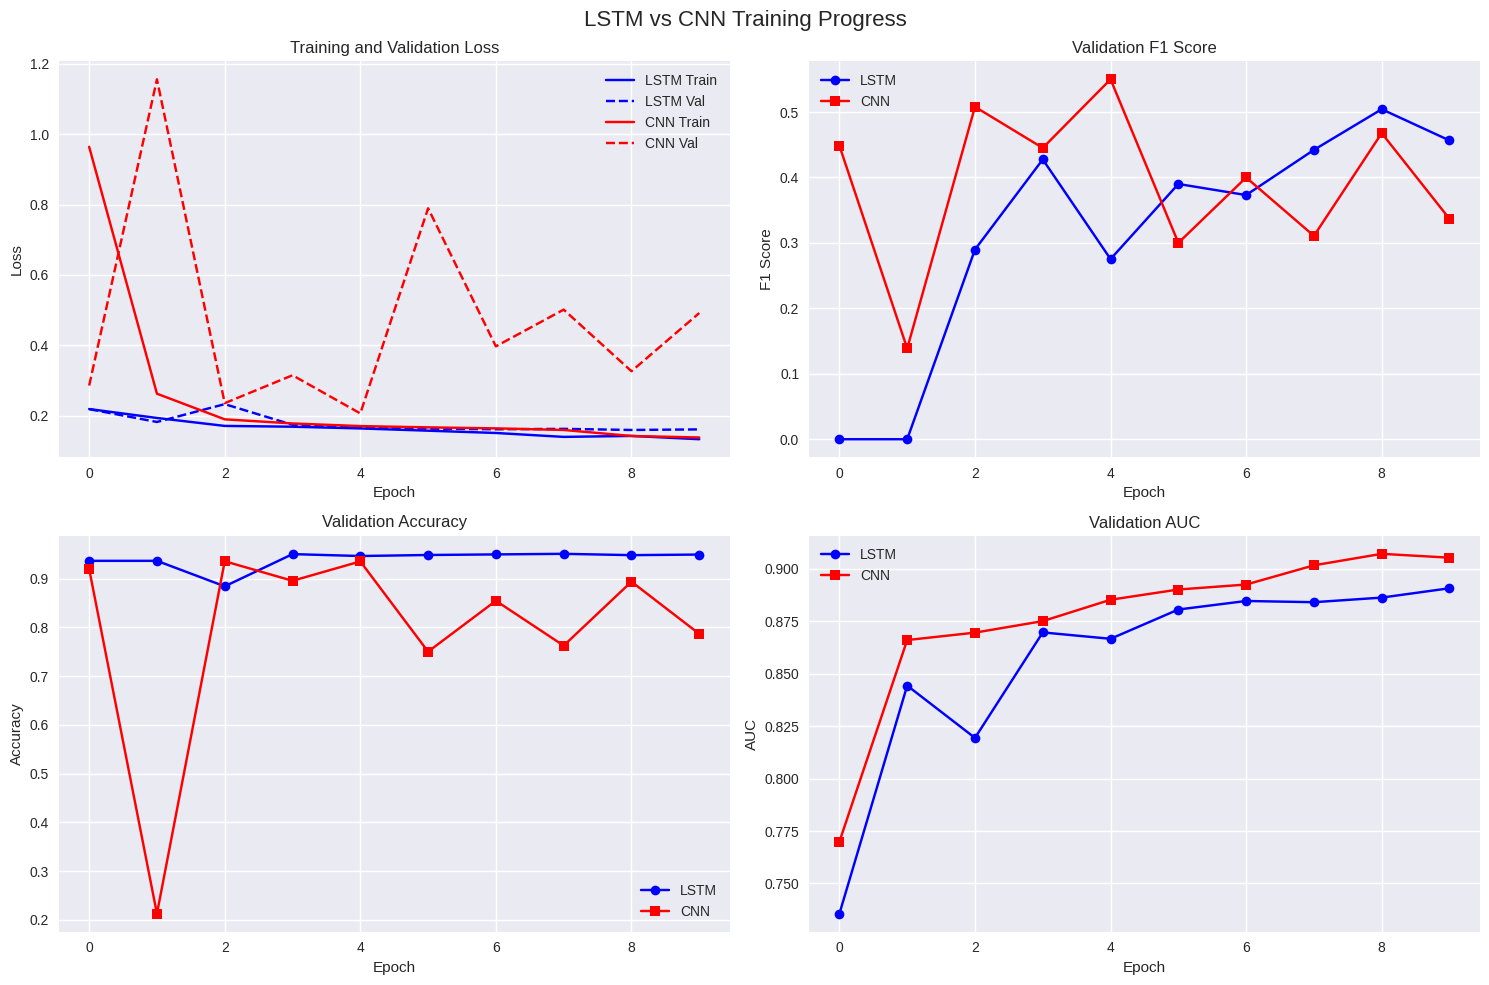

📈 Training curves saved!


In [15]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LSTM vs CNN Training Progress', fontsize=16)

# Loss curves
axes[0, 0].plot(lstm_history['train_loss'], label='LSTM Train', color='blue')
axes[0, 0].plot(lstm_history['val_loss'], label='LSTM Val', color='blue', linestyle='--')
axes[0, 0].plot(cnn_history['train_loss'], label='CNN Train', color='red')
axes[0, 0].plot(cnn_history['val_loss'], label='CNN Val', color='red', linestyle='--')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# F1 Score
axes[0, 1].plot(lstm_history['val_f1'], label='LSTM', color='blue', marker='o')
axes[0, 1].plot(cnn_history['val_f1'], label='CNN', color='red', marker='s')
axes[0, 1].set_title('Validation F1 Score')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Accuracy
axes[1, 0].plot(lstm_history['val_accuracy'], label='LSTM', color='blue', marker='o')
axes[1, 0].plot(cnn_history['val_accuracy'], label='CNN', color='red', marker='s')
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# AUC
axes[1, 1].plot(lstm_history['val_auc'], label='LSTM', color='blue', marker='o')
axes[1, 1].plot(cnn_history['val_auc'], label='CNN', color='red', marker='s')
axes[1, 1].set_title('Validation AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'visualizations' / f'lstm_cnn_training_curves_{TIMESTAMP}.png', dpi=300, bbox_inches='tight')
plt.show()

print("📈 Training curves saved!")

## 📋 Training Summary

In [16]:
# Create comprehensive training summary
print("📋 LSTM AND CNN TRAINING SUMMARY")
print("=" * 50)

print(f"\n🕒 Session: {TIMESTAMP}")
print(f"📊 Dataset: {len(train_dataset):,} train, {len(val_dataset):,} val, {len(test_dataset):,} test samples")
print(f"⚙️ Configuration: {TRAINING_CONFIG['epochs']} epochs, batch size {BATCH_SIZE}")

print(f"\n🧠 LSTM Model ({LSTM_RUN_NAME}):")
lstm_params = sum(p.numel() for p in lstm_model.parameters())
print(f"   Parameters: {lstm_params:,}")
print(f"   Best F1 (validation): {lstm_checkpoint['best_f1']:.4f}")
print(f"   Test Performance:")
for metric, value in lstm_test_metrics.items():
    print(f"     {metric}: {value:.4f}")

print(f"\n🔬 CNN Model ({CNN_RUN_NAME}):")
cnn_params = sum(p.numel() for p in cnn_model.parameters())
print(f"   Parameters: {cnn_params:,}")
print(f"   Best F1 (validation): {cnn_checkpoint['best_f1']:.4f}")
print(f"   Test Performance:")
for metric, value in cnn_test_metrics.items():
    print(f"     {metric}: {value:.4f}")

print(f"\n📁 Saved Models:")
print(f"   LSTM: {config.MODELS_DIR / f'{LSTM_RUN_NAME}.pt'}")
print(f"   CNN: {config.MODELS_DIR / f'{CNN_RUN_NAME}.pt'}")
print(f"   LSTM Checkpoint: {config.RESULTS_DIR / 'checkpoints' / f'best_model_{LSTM_RUN_NAME}.pt'}")
print(f"   CNN Checkpoint: {config.RESULTS_DIR / 'checkpoints' / f'best_model_{CNN_RUN_NAME}.pt'}")

print(f"\n🚀 Next Steps:")
print(f"   1. Run ensemble training: 10_ensemble_training.ipynb")
print(f"   2. Create comprehensive comparison: 11_comparative_analysis.ipynb")
print(f"   3. Final evaluation: 12_final_evaluation.ipynb")

print(f"\n💡 Usage Example for Loading Trained Models:")
print(f"```python")
print(f"import torch")
print(f"from notebook_utils import OptimizedLSTM, OptimizedCNN")
print(f"")
print(f"# Load LSTM")
print(f"lstm_checkpoint = torch.load('{config.MODELS_DIR / f'{LSTM_RUN_NAME}.pt'}')")
print(f"lstm_model = OptimizedLSTM(**lstm_checkpoint['model_config'])")
print(f"lstm_model.load_state_dict(lstm_checkpoint['model_state_dict'])")
print(f"")
print(f"# Load CNN")
print(f"cnn_checkpoint = torch.load('{config.MODELS_DIR / f'{CNN_RUN_NAME}.pt'}')")
print(f"cnn_model = OptimizedCNN(**cnn_checkpoint['model_config'])")
print(f"cnn_model.load_state_dict(cnn_checkpoint['model_state_dict'])")
print(f"```")

print("\n✅ LSTM and CNN training completed successfully!")

📋 LSTM AND CNN TRAINING SUMMARY

🕒 Session: 20251116_164028
📊 Dataset: 10,032 train, 3,344 val, 3,344 test samples
⚙️ Configuration: 10 epochs, batch size 16

🧠 LSTM Model (lstm_binary_20251116_164028):
   Parameters: 15,761,665
   Best F1 (validation): 0.5043
   Test Performance:
     accuracy: 0.9533
     precision: 0.5725
     recall: 0.4489
     f1: 0.5032
     auc: 0.9026
     avg_precision: 0.5329
     loss: 0.1381

🔬 CNN Model (cnn_binary_20251116_164028):
   Parameters: 14,049,121
   Best F1 (validation): 0.5500
   Test Performance:
     accuracy: 0.9396
     precision: 0.4504
     recall: 0.6705
     f1: 0.5388
     auc: 0.9081
     avg_precision: 0.5825
     loss: 0.1870

📁 Saved Models:
   LSTM: /home/netweb/vasu/smart-contract-vuln-detector/models/lstm_binary_20251116_164028.pt
   CNN: /home/netweb/vasu/smart-contract-vuln-detector/models/cnn_binary_20251116_164028.pt
   LSTM Checkpoint: /home/netweb/vasu/smart-contract-vuln-detector/results/checkpoints/best_model_lstm_bina